## Implementing Portfolio Insurance and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import edhec_risk_kit as erk
import numpy as np

Let's get the industry returns and the total market returns we calculated previously.

In [2]:
ind_returns = erk.get_ind_returns()
ind_tot_mkt_returns = erk.total_market_returns()

Now we have to allocate risky and safe assets. We are going to taje hypothetical safe assets which give a 3% return per year. 

In [38]:
risky_r = ind_returns["2000":][["Steel","Fin","Beer"]]

The shape of both the kinds of assets should be similar.

In [39]:
risky_r.shape

(228, 3)

In [40]:
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.shape

(228, 3)

We are considering the returns of all safe assets to be a constant throughout the year.

In [41]:
safe_r[:] = 0.03/12
start = 1000 #initial investment value
floor = 0.8 #we keep the floor at 80% of the investment value

Now, all we have to do is to calculate:
1. Cushion (Asset Value minus Floor Value)
2. Compute an allocation to safe and risky assets
3. Recompute the asset value based on returns

In [46]:
dates = ind_returns["2000":].index
n_steps = len(dates)
floor_value = start*floor
account_value = start
m = 3
#we will store the values for the account, cushion and allocated value for risky assets
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

In [47]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    #the weights allocated to risky assets shouldn't exceed 100% and should be non-negative
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    ##update the account value
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    #save the values in the history records
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    

Let's look at the account history of the Beer industry.

In [48]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


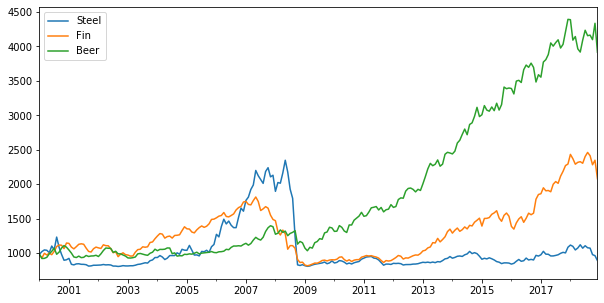

In [49]:
risky_wealth = start*(1+risky_r).cumprod()
account_history.plot(figsize=(10,5))

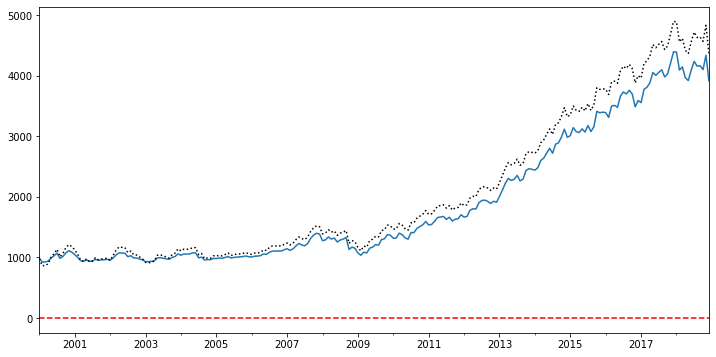

In [50]:
ax = account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor, color="r", linestyle="--")

Let's check the history of weights assigned to risky assets.

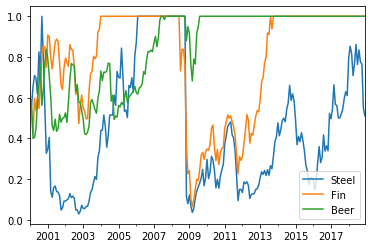

In [51]:
risky_w_history.plot()

We can see variations in the industries. The Beer industry has some variations in the start but end up in 100% allocation in the later years.